In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pathlib
from sklearn.metrics import f1_score
from geoband.API import *
import folium
import json
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, LineString
import jenkspy



import warnings

warnings.filterwarnings('ignore')


#Shapely 형태의 geometry 정보에서 내부 좌표들을 List로 반환.
def line_string_to_coordinates(line_string): 
    if isinstance(line_string, shapely.geometry.linestring.LineString): 
        lon, lat = line_string.xy 
        return [[x, y] for x, y in zip(lon, lat)] 
    elif isinstance(line_string, shapely.geometry.multilinestring.MultiLineString): 
        ret = [] 
        for i in range(len(line_string)): 
            lon, lat = line_string[i].xy 
            for x, y in zip(lon, lat): 
                ret.append([x, y])
        return ret 

def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

def polygon_to_coordinates(x): 
    lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

## 도로망 제공 데이터

In [2]:
GetCompasData('SBJ_2012_001', '23', '23.오산시_상세도로망_LV6.geojson')
GetCompasData('SBJ_2012_001', '24', '24.평일_전일,시간대별_오산시_추정교통량_Level6.csv')
GetCompasData('SBJ_2012_001', '25', '25.평일_전일_오산시_혼잡빈도강도_Level6.csv')
GetCompasData('SBJ_2012_001', '26', '26.평일_전일_오산시_혼잡시간강도_Level6.csv')

## 23. 오산시_상세도로망_LV6

In [3]:
data23 = gpd.read_file('23.오산시_상세도로망_LV6.geojson')
data23.head(5)

,link_id,max_speed,road_name,road_no,road_rank,link_type,road_type,facil_name,up_lanes,dw_lanes,oneway,length,width,car_lane,num_cross,barrier,geometry
0,478344684,60,수도권제2순환고속도로(봉담동탄,400,108,2,0,None,1,0,1,0.472,1,0,0,0,"MULTILINESTRING ((126.99779 37.17385, 126.9979..."
1,478344686,60,수도권제2순환고속도로(봉담동탄,400,108,2,0,None,2,0,1,0.606,2,0,0,0,"MULTILINESTRING ((126.99779 37.17385, 126.9978..."
2,478344690,60,수도권제2순환고속도로(봉담동탄,400,108,2,0,None,1,0,1,0.383,1,0,0,0,"MULTILINESTRING ((127.00104 37.18002, 127.0009..."
3,478344696,60,오산화성고속도로,171,108,2,0,None,1,0,1,0.488,1,0,0,0,"MULTILINESTRING ((126.99614 37.17621, 126.9963..."
4,478344700,40,오산화성고속도로,171,108,2,0,None,1,0,1,0.28,1,0,0,0,"MULTILINESTRING ((126.99770 37.17692, 126.9975..."


In [4]:
data23.drop('geometry', axis=1).describe(include='all')

,link_id,max_speed,road_name,road_no,road_rank,link_type,road_type,facil_name,up_lanes,dw_lanes,oneway,length,width,car_lane,num_cross,barrier
count,1875,1875,1581,1875,1875,1875,1875,33,1875,1875,1875,1875,1875,1875,1875,1875
unique,1875,10,120,10,6,10,6,26,5,5,2,408,4,2,3,5
top,571252046,0,경기대로,0,107,32768,0,세교터널,1,1,0,0.025,2,0,0,0
freq,1,627,136,1541,1541,1188,1831,4,1015,769,1460,28,751,1849,1846,1507


In [5]:
#도로폭, 길이, 최대속도, 횡단보도 개수는 Numeric Data로 취급 --> 변환

data23 = data23.astype(
    {'width': np.float,
     'length': np.float,
     'max_speed': np.float,
     'num_cross': np.float
    })

In [6]:
data23.isnull().sum()

link_id          0
max_speed        0
road_name      294
road_no          0
road_rank        0
link_type        0
road_type        0
facil_name    1842
up_lanes         0
dw_lanes         0
oneway           0
length           0
width            0
car_lane         0
num_cross        0
barrier          0
geometry         0
dtype: int64

In [7]:
data23.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   link_id     1875 non-null   object  
 1   max_speed   1875 non-null   float64 
 2   road_name   1581 non-null   object  
 3   road_no     1875 non-null   object  
 4   road_rank   1875 non-null   object  
 5   link_type   1875 non-null   object  
 6   road_type   1875 non-null   object  
 7   facil_name  33 non-null     object  
 8   up_lanes    1875 non-null   object  
 9   dw_lanes    1875 non-null   object  
 10  oneway      1875 non-null   object  
 11  length      1875 non-null   float64 
 12  width       1875 non-null   float64 
 13  car_lane    1875 non-null   object  
 14  num_cross   1875 non-null   float64 
 15  barrier     1875 non-null   object  
 16  geometry    1875 non-null   geometry
dtypes: float64(4), geometry(1), object(12)
memory usage: 249.1+ KB


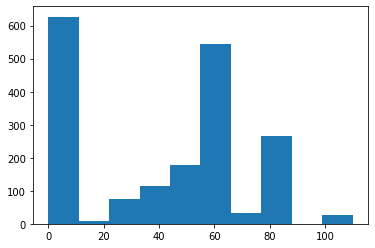

In [8]:
#최대 속도
plt.hist(data23['max_speed'])
plt.show()

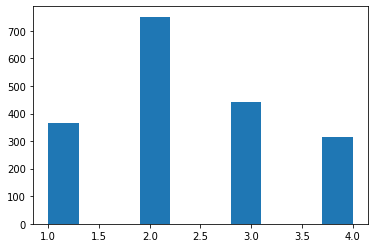

In [9]:
#도로폭
plt.hist(data23['width'])
plt.show()

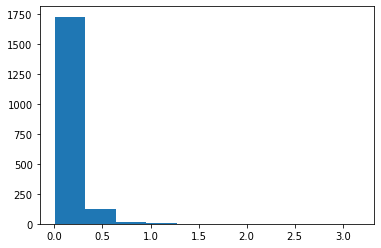

In [10]:
#도로 길이
plt.hist(data23['length'])
plt.show()

415


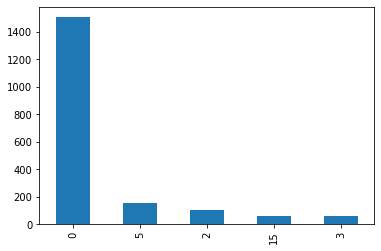

In [11]:
#중앙분리대 

data23['barrier'].value_counts().plot(kind='bar')
print(sum(data23['oneway']!='0'))
#0: 없음, 5: 금속, 2: 봉, 15:기타, 3: 화단 

1460
415


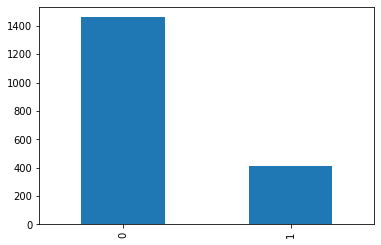

In [12]:
#일방통행 여부

data23['oneway'].value_counts().plot(kind='bar')
print(sum(data23['oneway']=='0'))
print(sum(data23['oneway']=='1'))

#일방통행이 아닌 양방통행 도로의 경우 전부 중앙분리대가 있음.

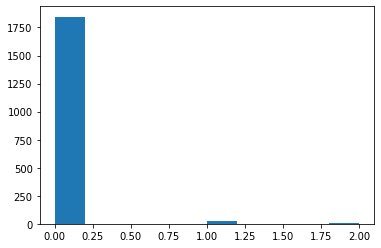

32.0


In [13]:
#횡단보도 개수

plt.hist(data23['num_cross'])
plt.show()
print(sum(data23['num_cross']))

## 24. 추정교통량

In [14]:
data24 = pd.read_csv('24.평일_전일,시간대별_오산시_추정교통량_Level6.csv')
data24.head(5)

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,시간적범위,평일주말,전체 추정교통량,승용차 추정교통량,버스 추정교통량,화물차 추정교통량
0,57137697901,101,0.093,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,0,평일,268.55,193.43,11.99,63.13
1,57135249601,101,0.324,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,0,평일,21.98,15.48,0.75,5.74
2,57135250601,101,0.333,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,0,평일,15.77,9.55,1.50,4.73
3,57137696601,101,0.372,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,0,평일,179.55,135.99,5.22,38.35
4,57137697701,101,0.667,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,0,평일,267.91,192.96,11.96,62.99


In [15]:
data24.describe(include='all')

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,시간적범위,평일주말,전체 추정교통량,승용차 추정교통량,버스 추정교통량,화물차 추정교통량
count,8.197500e+04,81975.000000,81975.000000,69075,81975,81975,81975,81975,81975,81975.000000,81975.000000,81975.000000,81975.000000
unique,NaN,NaN,NaN,120,1,1,6,49,1,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,경기대로,경기도,오산시,신장동,전일,평일,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,5750,81975,81975,20275,3279,81975,NaN,NaN,NaN,NaN
mean,5.712641e+10,106.608112,0.120636,NaN,NaN,NaN,NaN,NaN,NaN,483.963280,405.490657,8.755831,69.716644
std,9.326520e+08,1.101092,0.153740,NaN,NaN,NaN,NaN,NaN,NaN,2069.872552,1676.803712,66.802921,347.093994
min,4.783447e+10,101.000000,0.004000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,5.712450e+10,107.000000,0.036000,NaN,NaN,NaN,NaN,NaN,NaN,24.470000,20.850000,0.030000,1.450000
50%,5.712523e+10,107.000000,0.074000,NaN,NaN,NaN,NaN,NaN,NaN,96.340000,83.780000,0.360000,10.600000
75%,5.713539e+10,107.000000,0.153000,NaN,NaN,NaN,NaN,NaN,NaN,357.700000,306.990000,3.320000,47.295000


In [16]:
#상세도로망_LinkID와 도로등급은 categorical 정보인데 숫자로 분류되고 있으므로 변환해준다.
#또한 시간적범위가 어떤 값은 string으로 어떤 값은 numeric 값으로 분류되고 있으므로 string 값으로 통합해주자.

for column in ['상세도로망_LinkID', '도로등급', '시간적범위']:
    data24[column] = data24[column].apply(str)

In [17]:
#상행 하행 정보를 제외한 link_id 열 추가

link_id = []
for i in range(len(data24)):
    link_id.append(data24.상세도로망_LinkID[i][:-2])
link_id = pd.DataFrame({'link_id':link_id})
data24 = pd.concat([link_id, data24], axis=1)
data24.head(3)  

,link_id,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,시간적범위,평일주말,전체 추정교통량,승용차 추정교통량,버스 추정교통량,화물차 추정교통량
0,571376979,57137697901,101,0.093,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,0,평일,268.55,193.43,11.99,63.13
1,571352496,57135249601,101,0.324,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,0,평일,21.98,15.48,0.75,5.74
2,571352506,57135250601,101,0.333,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,0,평일,15.77,9.55,1.50,4.73


In [18]:
#시간에 따른 추정교통량을 쟀음을 확인 가능.

data24['시간적범위'].value_counts()

1     3279
22    3279
5     3279
10    3279
2     3279
15    3279
13    3279
11    3279
19    3279
12    3279
8     3279
17    3279
0     3279
7     3279
9     3279
20    3279
14    3279
21    3279
23    3279
16    3279
18    3279
4     3279
3     3279
6     3279
전일    3279
Name: 시간적범위, dtype: int64

In [19]:
data24.isnull().sum()

link_id             0
상세도로망_LinkID        0
도로등급                0
링크길이                0
도로명             12900
시도명                 0
시군구명                0
읍면동명                0
시간적범위               0
평일주말                0
전체 추정교통량            0
승용차 추정교통량           0
버스 추정교통량            0
화물차 추정교통량           0
dtype: int64

In [20]:
#어린이 교통사고는 야심한 밤이나 너무 이른 아침에는 일어나지 않을 것이라고 가정.
#따라서 오전 7시부터 밤 24시까지의 데이터만 사용.
#특히 어린이 교통사고가 일어날 가능성이 높은 하교 시간 및 학원 이동 시간대(14-20)에는 가중치를 주기로 함.

time_list = list(map(str, list(range(7,25,1))))
교통량 = data24[data24['시간적범위'].isin(time_list)]

In [21]:
weighted_list = list(map(str, list(range(14,21,1))))
new_value = 교통량.loc[교통량['시간적범위'].isin(weighted_list),'전체 추정교통량']*2
교통량.loc[교통량.시간적범위.isin(weighted_list),'전체 추정교통량'] = new_value

In [22]:
교통량.head(5)

,link_id,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,시간적범위,평일주말,전체 추정교통량,승용차 추정교통량,버스 추정교통량,화물차 추정교통량
42,571376979,57137697901,101,0.093,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,10,평일,1779.64,1340.69,54.30,384.65
43,571352496,57135249601,101,0.324,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,10,평일,128.51,92.75,4.60,31.16
44,571352506,57135250601,101,0.333,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,10,평일,109.72,74.09,6.30,29.32
45,571376966,57137696601,101,0.372,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,10,평일,1151.67,860.95,41.75,248.96
46,571376977,57137697701,101,0.667,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,10,평일,1776.17,1338.02,54.21,383.94


In [23]:
#시도명과 시군구명은 경기도 오산시로 전부 동일하므로 제외하고 교통량은 전체 교통량만을 고려하자. 평일주말 역시 평일밖에 없으므로 제외

교통량 = 교통량[교통량.columns.difference(['시도명','시군구명','승용차 추정교통량', '버스 추정교통량', '화물차 추정교통량', '평일주말'])]

In [24]:
교통량.head(5)

,link_id,도로등급,도로명,링크길이,상세도로망_LinkID,시간적범위,읍면동명,전체 추정교통량
42,571376979,101,수도권제2순환고속도로(봉담동탄,0.093,57137697901,10,세마동,1779.64
43,571352496,101,수도권제2순환고속도로(봉담동탄,0.324,57135249601,10,세마동,128.51
44,571352506,101,수도권제2순환고속도로(봉담동탄,0.333,57135250601,10,세마동,109.72
45,571376966,101,수도권제2순환고속도로(봉담동탄,0.372,57137696601,10,세마동,1151.67
46,571376977,101,수도권제2순환고속도로(봉담동탄,0.667,57137697701,10,세마동,1776.17


In [25]:
# 시간대별 교통량 합치기

교통량_colname = 교통량.columns.tolist()
교통량_colname.remove('전체 추정교통량')
교통량_colname.remove('시간적범위')
교통량_colname.remove('도로명')
통합교통량 = 교통량.groupby(교통량_colname, as_index=False).sum()
통합교통량 = pd.merge(통합교통량, 교통량.iloc[:,[0,2]], on='link_id', how='left')
통합교통량 = 통합교통량.drop_duplicates(['link_id', '상세도로망_LinkID'], keep='first')
통합교통량 = 통합교통량[['link_id', '상세도로망_LinkID', '도로명', '도로등급', '링크길이', '읍면동명', '전체 추정교통량']]

### 25. 평일_전일_오산시_혼잡빈도강도_Level6

In [26]:
data25 = pd.read_csv('25.평일_전일_오산시_혼잡빈도강도_Level6.csv')
data25.head(5)

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,시간적범위,평일주말,혼잡빈도강도
0,57125499201,101,1.238,경부고속도로,경기도,오산시,대원동,전일,평일,49.10
1,57125499001,101,1.335,경부고속도로,경기도,오산시,대원동,전일,평일,70.67
2,57137697901,101,0.093,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,전일,평일,42.61
3,57135249601,101,0.324,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,전일,평일,96.75
4,57135250601,101,0.333,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,전일,평일,99.95


In [27]:
#데이터 type 확인

data25.describe(include='all')

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,시간적범위,평일주말,혼잡빈도강도
count,3.032000e+03,3032.000000,3032.000000,2650,3032,3032,3032,3032,3032,3032.000000
unique,NaN,NaN,NaN,119,1,1,6,1,1,NaN
top,NaN,NaN,NaN,경기대로,경기도,오산시,신장동,전일,평일,NaN
freq,NaN,NaN,NaN,227,3032,3032,751,3032,3032,NaN
mean,5.714750e+10,106.567282,0.123483,NaN,NaN,NaN,NaN,NaN,NaN,59.354057
std,8.609055e+08,1.132041,0.156877,NaN,NaN,NaN,NaN,NaN,NaN,33.698739
min,4.783447e+10,101.000000,0.004000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,5.712446e+10,107.000000,0.037000,NaN,NaN,NaN,NaN,NaN,NaN,28.177500
50%,5.712520e+10,107.000000,0.076000,NaN,NaN,NaN,NaN,NaN,NaN,66.225000
75%,5.713539e+10,107.000000,0.157000,NaN,NaN,NaN,NaN,NaN,NaN,91.985000


In [28]:
#상세도로망과 도로등급 데이터 타입 변환

for column in ['상세도로망_LinkID', '도로등급']:
    data25[column] = data25[column].apply(str)
    
data25.describe(include='all')

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,시간적범위,평일주말,혼잡빈도강도
count,3032,3032,3032.000000,2650,3032,3032,3032,3032,3032,3032.000000
unique,3032,5,NaN,119,1,1,6,1,1,NaN
top,57124169701,107,NaN,경기대로,경기도,오산시,신장동,전일,평일,NaN
freq,1,2506,NaN,227,3032,3032,751,3032,3032,NaN
mean,NaN,NaN,0.123483,NaN,NaN,NaN,NaN,NaN,NaN,59.354057
std,NaN,NaN,0.156877,NaN,NaN,NaN,NaN,NaN,NaN,33.698739
min,NaN,NaN,0.004000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,0.037000,NaN,NaN,NaN,NaN,NaN,NaN,28.177500
50%,NaN,NaN,0.076000,NaN,NaN,NaN,NaN,NaN,NaN,66.225000
75%,NaN,NaN,0.157000,NaN,NaN,NaN,NaN,NaN,NaN,91.985000


In [29]:
data25.isnull().sum()

상세도로망_LinkID      0
도로등급              0
링크길이              0
도로명             382
시도명               0
시군구명              0
읍면동명              0
시간적범위             0
평일주말              0
혼잡빈도강도            0
dtype: int64

### 26.평일_전일_오산시_혼잡시간강도_Level6

In [30]:
data26=pd.read_csv('26.평일_전일_오산시_혼잡시간강도_Level6.csv')
data26.head(5)

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,시간적범위,평일주말,혼잡시간강도
0,57125499201,101,1.238,경부고속도로,경기도,오산시,대원동,전일,평일,59.66
1,57125499001,101,1.335,경부고속도로,경기도,오산시,대원동,전일,평일,77.13
2,57137697901,101,0.093,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,전일,평일,50.79
3,57135249601,101,0.324,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,전일,평일,99.75
4,57135250601,101,0.333,수도권제2순환고속도로(봉담동탄,경기도,오산시,세마동,전일,평일,99.99


In [31]:
#데이터 타입 확인

data26.describe(include='all')

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,시간적범위,평일주말,혼잡시간강도
count,3.032000e+03,3032.000000,3032.000000,2650,3032,3032,3032,3032,3032,3032.000000
unique,NaN,NaN,NaN,119,1,1,6,1,1,NaN
top,NaN,NaN,NaN,경기대로,경기도,오산시,신장동,전일,평일,NaN
freq,NaN,NaN,NaN,227,3032,3032,751,3032,3032,NaN
mean,5.714750e+10,106.567282,0.123483,NaN,NaN,NaN,NaN,NaN,NaN,74.829852
std,8.609055e+08,1.132041,0.156877,NaN,NaN,NaN,NaN,NaN,NaN,29.287752
min,4.783447e+10,101.000000,0.004000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,5.712446e+10,107.000000,0.037000,NaN,NaN,NaN,NaN,NaN,NaN,58.455000
50%,5.712520e+10,107.000000,0.076000,NaN,NaN,NaN,NaN,NaN,NaN,88.000000
75%,5.713539e+10,107.000000,0.157000,NaN,NaN,NaN,NaN,NaN,NaN,98.160000


In [32]:
#상세도로망과 도로등급 데이터 타입 변환

for column in ['상세도로망_LinkID', '도로등급']:
    data26[column] = data26[column].apply(str)
    
data26.describe(include='all')

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,시간적범위,평일주말,혼잡시간강도
count,3032,3032,3032.000000,2650,3032,3032,3032,3032,3032,3032.000000
unique,3032,5,NaN,119,1,1,6,1,1,NaN
top,57124568502,107,NaN,경기대로,경기도,오산시,신장동,전일,평일,NaN
freq,1,2506,NaN,227,3032,3032,751,3032,3032,NaN
mean,NaN,NaN,0.123483,NaN,NaN,NaN,NaN,NaN,NaN,74.829852
std,NaN,NaN,0.156877,NaN,NaN,NaN,NaN,NaN,NaN,29.287752
min,NaN,NaN,0.004000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,0.037000,NaN,NaN,NaN,NaN,NaN,NaN,58.455000
50%,NaN,NaN,0.076000,NaN,NaN,NaN,NaN,NaN,NaN,88.000000
75%,NaN,NaN,0.157000,NaN,NaN,NaN,NaN,NaN,NaN,98.160000


### 혼잡빈도강도 + 혼잡시간강도

In [33]:
# 혼잡빈도강도 + 혼잡시간강도
# 시도명, 시군구명, 시간적범위, 평일주말은 모두 동일하므로 생략.
data25_part = data25.loc[:, ['상세도로망_LinkID', '혼잡빈도강도']]
혼잡도 = pd.merge(data25_part, data26, on='상세도로망_LinkID', how='outer')
혼잡도 = 혼잡도[['상세도로망_LinkID', '도로등급', '링크길이', '도로명', '혼잡시간강도', '혼잡빈도강도']]
혼잡도.head(5)

,상세도로망_LinkID,도로등급,링크길이,도로명,혼잡시간강도,혼잡빈도강도
0,57125499201,101,1.238,경부고속도로,59.66,49.10
1,57125499001,101,1.335,경부고속도로,77.13,70.67
2,57137697901,101,0.093,수도권제2순환고속도로(봉담동탄,50.79,42.61
3,57135249601,101,0.324,수도권제2순환고속도로(봉담동탄,99.75,96.75
4,57135250601,101,0.333,수도권제2순환고속도로(봉담동탄,99.99,99.95


In [34]:
#상행_하행 제거 Link ID 추가

link_id = []
for i in range(len(혼잡도)):
    link_id.append(혼잡도.상세도로망_LinkID[i][:-2])
link_id = pd.DataFrame({'link_id':link_id})
혼잡도 = pd.concat([link_id, 혼잡도], axis=1)
혼잡도.head()

,link_id,상세도로망_LinkID,도로등급,링크길이,도로명,혼잡시간강도,혼잡빈도강도
0,571254992,57125499201,101,1.238,경부고속도로,59.66,49.10
1,571254990,57125499001,101,1.335,경부고속도로,77.13,70.67
2,571376979,57137697901,101,0.093,수도권제2순환고속도로(봉담동탄,50.79,42.61
3,571352496,57135249601,101,0.324,수도권제2순환고속도로(봉담동탄,99.75,96.75
4,571352506,57135250601,101,0.333,수도권제2순환고속도로(봉담동탄,99.99,99.95


In [35]:
혼잡도.describe(include='all')

,link_id,상세도로망_LinkID,도로등급,링크길이,도로명,혼잡시간강도,혼잡빈도강도
count,3032,3032,3032,3032.000000,2650,3032.000000,3032.000000
unique,1724,3032,5,NaN,119,NaN,NaN
top,571252046,57124169701,107,NaN,경기대로,NaN,NaN
freq,2,1,2506,NaN,227,NaN,NaN
mean,NaN,NaN,NaN,0.123483,NaN,74.829852,59.354057
std,NaN,NaN,NaN,0.156877,NaN,29.287752,33.698739
min,NaN,NaN,NaN,0.004000,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,0.037000,NaN,58.455000,28.177500
50%,NaN,NaN,NaN,0.076000,NaN,88.000000,66.225000
75%,NaN,NaN,NaN,0.157000,NaN,98.160000,91.985000


## 통합교통량 + 혼잡도

In [36]:
#혼잡도에는 존재하지만 통합교통량에는 존재하지 않는 데이터 존재.
#결측치 --> median으로 처리

교통정보 = 통합교통량.merge(혼잡도, on=['상세도로망_LinkID'], how='outer')
교통정보 = 교통정보[교통정보.columns.difference(['link_id_y', '도로등급_y', '링크길이_y', '도로명_y'])]

교통정보['혼잡빈도강도'].fillna(value=교통정보.median()['혼잡빈도강도'], inplace=True)
교통정보['혼잡시간강도'].fillna(value=교통정보.median()['혼잡시간강도'], inplace=True)

#바뀐 컬럼 이름 변경
교통정보.rename(columns = {'link_id_x': 'link_id', '도로등급_x': '도로등급', '도로명_x':'도로명', '링크길이_x':'링크길이'}, inplace=True)

#바뀐 컬럼 순서 변경
교통정보 = 교통정보[['link_id', '상세도로망_LinkID', '도로명', '도로등급', '링크길이','읍면동명', '전체 추정교통량', '혼잡빈도강도', '혼잡시간강도']]

In [37]:
#상행 하행 평균내기

교통정보_평균 = 교통정보.groupby(['link_id', '읍면동명', '도로등급'], as_index=False).mean()
도로명정보 = 교통정보.loc[:, ['link_id', '도로명']].drop_duplicates('link_id', keep='first')

교통정보_평균 = pd.merge(교통정보_평균, 도로명정보, on='link_id')

교통정보_평균.head(3)

,link_id,읍면동명,도로등급,링크길이,전체 추정교통량,혼잡빈도강도,혼잡시간강도,도로명
0,478344684,세마동,108,0.472,24459.32,66.225,88.0,수도권제2순환고속도로(봉담동탄
1,478344686,세마동,108,0.606,12871.81,66.225,88.0,수도권제2순환고속도로(봉담동탄
2,478344690,세마동,108,0.383,3271.42,66.225,88.0,수도권제2순환고속도로(봉담동탄


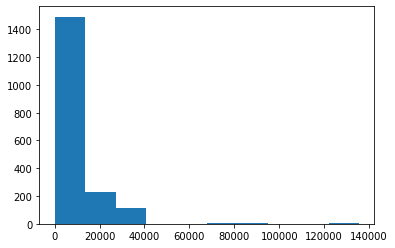

In [38]:
##교통량(전체) 히스토그램
plt.hist(교통정보_평균['전체 추정교통량'])
plt.show()

### 교통량(전체) 단계구분(5단계)

In [39]:
breaks = jenkspy.jenks_breaks(교통정보_평균['전체 추정교통량'], nb_class = 5)
print(breaks)
교통정보_평균['교통량단계'] = pd.cut(교통정보_평균['전체 추정교통량'],
                                bins=breaks,
                                labels=['break_1', 'break_2', 'break_3', 'break_4', 'break_5'],
                               include_lowest=True)

단계구분_교통량 = 교통정보_평균.groupby(['교통량단계'], as_index=False).count()
단계구분_교통량

[0.0, 5637.5999999999985, 14428.71, 25810.865000000005, 38466.52, 135558.45]


,교통량단계,link_id,읍면동명,도로등급,링크길이,전체 추정교통량,혼잡빈도강도,혼잡시간강도,도로명
0,break_1,1069,1069,1069,1069,1069,1069,1069,800
1,break_2,439,439,439,439,439,439,439,421
2,break_3,205,205,205,205,205,205,205,205
3,break_4,117,117,117,117,117,117,117,117
4,break_5,13,13,13,13,13,13,13,13


### 도로정보 시각화

In [40]:
# mapbox
from mapboxgl.viz import LinestringViz
from mapboxgl.utils import create_color_stops, create_numeric_stops

In [41]:
m_도로망 = data23.copy()

#도로폭 정규화
m_도로망['정규화도로폭'] = m_도로망['width'] / m_도로망['width'].max()

#Line string 좌표를 list안에 넣기
m_도로망['geometry'] = m_도로망['geometry'].apply(line_string_to_coordinates)
m_도로망 = pd.DataFrame(m_도로망) #뒤에 시각화 툴 사용을 위해 dataframe 형태 변환
m_도로망.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   link_id     1875 non-null   object 
 1   max_speed   1875 non-null   float64
 2   road_name   1581 non-null   object 
 3   road_no     1875 non-null   object 
 4   road_rank   1875 non-null   object 
 5   link_type   1875 non-null   object 
 6   road_type   1875 non-null   object 
 7   facil_name  33 non-null     object 
 8   up_lanes    1875 non-null   object 
 9   dw_lanes    1875 non-null   object 
 10  oneway      1875 non-null   object 
 11  length      1875 non-null   float64
 12  width       1875 non-null   float64
 13  car_lane    1875 non-null   object 
 14  num_cross   1875 non-null   float64
 15  barrier     1875 non-null   object 
 16  geometry    1875 non-null   object 
 17  정규화도로폭      1875 non-null   float64
dtypes: float64(5), object(13)
memory usage: 263.8+ KB


In [42]:
m_교통량 = 교통정보_평균.merge(m_도로망, on='link_id')

In [44]:
#시각화에 필요한 열만 선택
선택열 = ['link_id','도로명', '전체 추정교통량', '혼잡시간강도', '혼잡빈도강도', '교통량단계', 'link_type', '정규화도로폭', 'geometry']
data_subset = m_교통량[선택열]

### Dataframe을 Geojson 파일로 변환

In [45]:
def df_to_geojson(df, properties, geometry = 'geometry'):
    # geojson 형식을 사용하여 geojson 데이터를 포함하는 새로운 파이썬 사전을 만듭니다.
    geojson = {'type':'FeatureCollection', 'features':[]}

    # 데이터 프레임의 각 행을 반복하고 각 행을 geojson 형식으로 변환
    for _, row in df.iterrows():
        # create a feature template to fill in
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{"type": "MultiLineString",
                               "coordinates":[]}}

        # 좌표를 입력
        feature['geometry']["coordinates"] = [row[geometry]]

        # 각 열에 대해 값을 가져 와서 새 feature 속성으로 추가합니다.
        for prop in properties:
            feature['properties'][prop] = row[prop]
        
        # 변환 된 데이터 프레임 행을 dict 내의 기능 목록에 추가
        geojson['features'].append(feature)
    
    return geojson

In [46]:
#mapbox token
token = 'pk.eyJ1IjoiZXNqMjA1IiwiYSI6ImNrandteXcycjA1Z3gyeW94ODJudXMyZjkifQ.f3Kf3HT8SbRevEV9SNc6hQ'

In [47]:
geojson = df_to_geojson(data_subset, 선택열)

### Mapbox Viz (전체 교통량)

In [53]:
color_breaks = jenkspy.jenks_breaks(교통정보_평균['전체 추정교통량'], nb_class = 5)
color_stops = create_color_stops(color_breaks, colors='YlOrBr')

viz = LinestringViz(geojson,
                access_token= token, 
                color_property = "전체 추정교통량",
                color_stops = color_stops,
                line_width_property="정규화도로폭",
                line_width_stops=create_numeric_stops([0, 0.2, 0.4, 0.6, 0.8, 1.0], 1, 10),
                opacity=0.8,
                center = (127.05128286756862, 37.16323633764299),
                zoom = 12,
                below_layer = 'waterway-label')
viz.show()

### 혼잡시간빈도

In [51]:
color_breaks = jenkspy.jenks_breaks(교통정보_평균['혼잡시간강도'], nb_class = 5)
color_stops = create_color_stops(color_breaks, colors='OrRd')

viz = LinestringViz(geojson,
                access_token= token, 
                color_property = "혼잡시간강도",
                color_stops = color_stops,
                line_width_property="정규화도로폭",
                line_width_stops=create_numeric_stops([0, 0.2, 0.4, 0.6, 0.8, 1.0], 1, 10),
                opacity=0.8,
                center = (127.05128286756862, 37.16323633764299),
                zoom = 12,
                below_layer = 'waterway-label')
viz.show()

### 혼잡빈도강도

In [54]:
color_breaks = jenkspy.jenks_breaks(교통정보_평균['혼잡빈도강도'], nb_class = 5)
color_stops = create_color_stops(color_breaks, colors='YlOrRd')

viz = LinestringViz(geojson,
                access_token= token, 
                color_property = "혼잡빈도강도",
                color_stops = color_stops,
                line_width_property="정규화도로폭",
                line_width_stops=create_numeric_stops([0, 0.2, 0.4, 0.6, 0.8, 1.0], 1, 10),
                opacity=0.8,
                center = (127.05128286756862, 37.16323633764299),
                zoom = 12,
                below_layer = 'waterway-label')
viz.show()